# Imports

In [1]:
import warnings
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import yfinance as yf
import itertools

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from prophet.plot import add_changepoints_to_plot

warnings.filterwarnings('ignore')


def min_max(df):
    print(f"menor data: {df['data'].min()} maior data: {df['data'].max()}")

# 1. Baixando dados
-----------------------------------------------
- Utilizando os dados do preço do petróleo brent (FOB)
- Fonte: http://www.ipeadata.gov.br/Default.aspx
- Período: 1986-2024 
- Objetivo: obter uma previsão diária do valor do barril de petróleo

In [2]:
# Baixando os dados do preço do petróleo brent de 86 a 2024

ipea_full_rev = pd.read_excel('dados_ipea_86_24_rev.xlsx')
ipea_full_rev.shape

(14012, 2)

In [3]:
(ipea_full_rev.data.min()), (ipea_full_rev.data.max())

(Timestamp('1986-01-02 00:00:00'), Timestamp('2024-05-13 00:00:00'))

In [4]:
# Verificando os NA'seasonal_decompose

ipea_full_rev.isna().sum()

data                           0
preco_petroleo_brent_usd    2532
dtype: int64

- Optou-se por utilizar os dados de 2019 - 2023

In [5]:
# Utilizando apenas os dados de 2019 a 2023

filtro_data_2 = ((ipea_full_rev.data >= '2018-12-29') # utilizando a partir do dia 29/09/2018 em fç do preenchimento de NA's
              &
              (ipea_full_rev.data <= '2023-12-31')
              )

# Aplicando o filtro

ipea_full_period_2 = ipea_full_rev[filtro_data_2]

(ipea_full_period_2.data.min()), (ipea_full_period_2.data.max()), (ipea_full_period_2.shape)

(Timestamp('2018-12-29 00:00:00'), Timestamp('2023-12-31 00:00:00'), (1829, 2))

In [6]:
# Apenas para análise, utilizando os dados de 2013 a 2023

filtro_data_3 = ((ipea_full_rev.data >= '2012-12-29') # utilizando a partir do dia 29/09/2018 em fç do preenchimento de NA's
              &
              (ipea_full_rev.data <= '2023-12-31')
              )

# Aplicando o filtro

ipea_full_period_3 = ipea_full_rev[filtro_data_3]

(ipea_full_period_3.data.min()), (ipea_full_period_3.data.max()), (ipea_full_period_3.shape)

(Timestamp('2012-12-29 00:00:00'), Timestamp('2023-12-31 00:00:00'), (4020, 2))

## 1.1 Verificando os NA's
---------------------------------------------
- Os valores vazios foram preenchido com o último valor preenchido anterior à ele

### Dados de 2013-2023

In [7]:
# Com dados desde 2012

ipea_full_period_3.isna().sum()

data                          0
preco_petroleo_brent_usd    638
dtype: int64

In [8]:
# Preenchendo os NA's

ipea_full_period_3['novos_valores'] = ipea_full_period_3.preco_petroleo_brent_usd.fillna(method='ffill')

# Ficando apenas com os dados de 2013-2023

filtro_data_modelo_2 = (ipea_full_period_3.data >= '2013-01-01')

df_inicial_ajustado_2 = ipea_full_period_3[filtro_data_modelo_2]

(df_inicial_ajustado_2.data.min()), (df_inicial_ajustado_2.data.max())

(Timestamp('2013-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00'))

In [9]:
df_inicial_ajustado_2.isna().sum()

data                          0
preco_petroleo_brent_usd    637
novos_valores                 0
dtype: int64

### Dados de 2019-2023

In [10]:
# Com dados desde 2019

ipea_full_period_2.isna().sum()

data                          0
preco_petroleo_brent_usd    569
dtype: int64

In [11]:
# Preenchendo os NA's

ipea_full_period_2['novos_valores'] = ipea_full_period_2.preco_petroleo_brent_usd.fillna(method='ffill')
(ipea_full_period_2.isna().sum())

data                          0
preco_petroleo_brent_usd    569
novos_valores                 0
dtype: int64

In [12]:
# Ficando apenas co os dados de 2019-2023

filtro_data_modelo = (ipea_full_period_2.data >= '2019-01-01')

df_inicial_ajustado = ipea_full_period_2[filtro_data_modelo]

(df_inicial_ajustado.data.min()), (df_inicial_ajustado.data.max())

(Timestamp('2019-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00'))

# 2.0 Avaliação preliminar da série 

## 2.1 Período de 2013-2023

In [13]:
# Avaliando a série temporal
# Ajustando o dataframe para a análise

df_analise_maior = df_inicial_ajustado_2[['data', 'novos_valores']]
df_analise_maior.columns = ['data', 'novos_valores_preco_pret_usd']

# Ajustando a data como índice

df_analise_maior = df_analise_maior.set_index('data')

In [10]:
# Gráfico de série temporal

serie_preco_petro_maior = px.line(df_analise_maior, x=df_analise_maior.index, y='novos_valores_preco_pret_usd')
serie_preco_petro_maior.show();

## 2.2 Período de 2019-2023

In [14]:
# Avaliando a série temporal
# Ajustando o dataframe para a análise

df_analise = df_inicial_ajustado[['data', 'novos_valores']]
df_analise.columns = ['data', 'novos_valores_preco_pret_usd']

# Ajustando a data como índice

df_analise = df_analise.set_index('data')

In [22]:
# Gráfico de série temporal

serie_preco_petro_2 = px.line(df_analise, x=df_analise.index, y='novos_valores_preco_pret_usd')
serie_preco_petro_2.show();

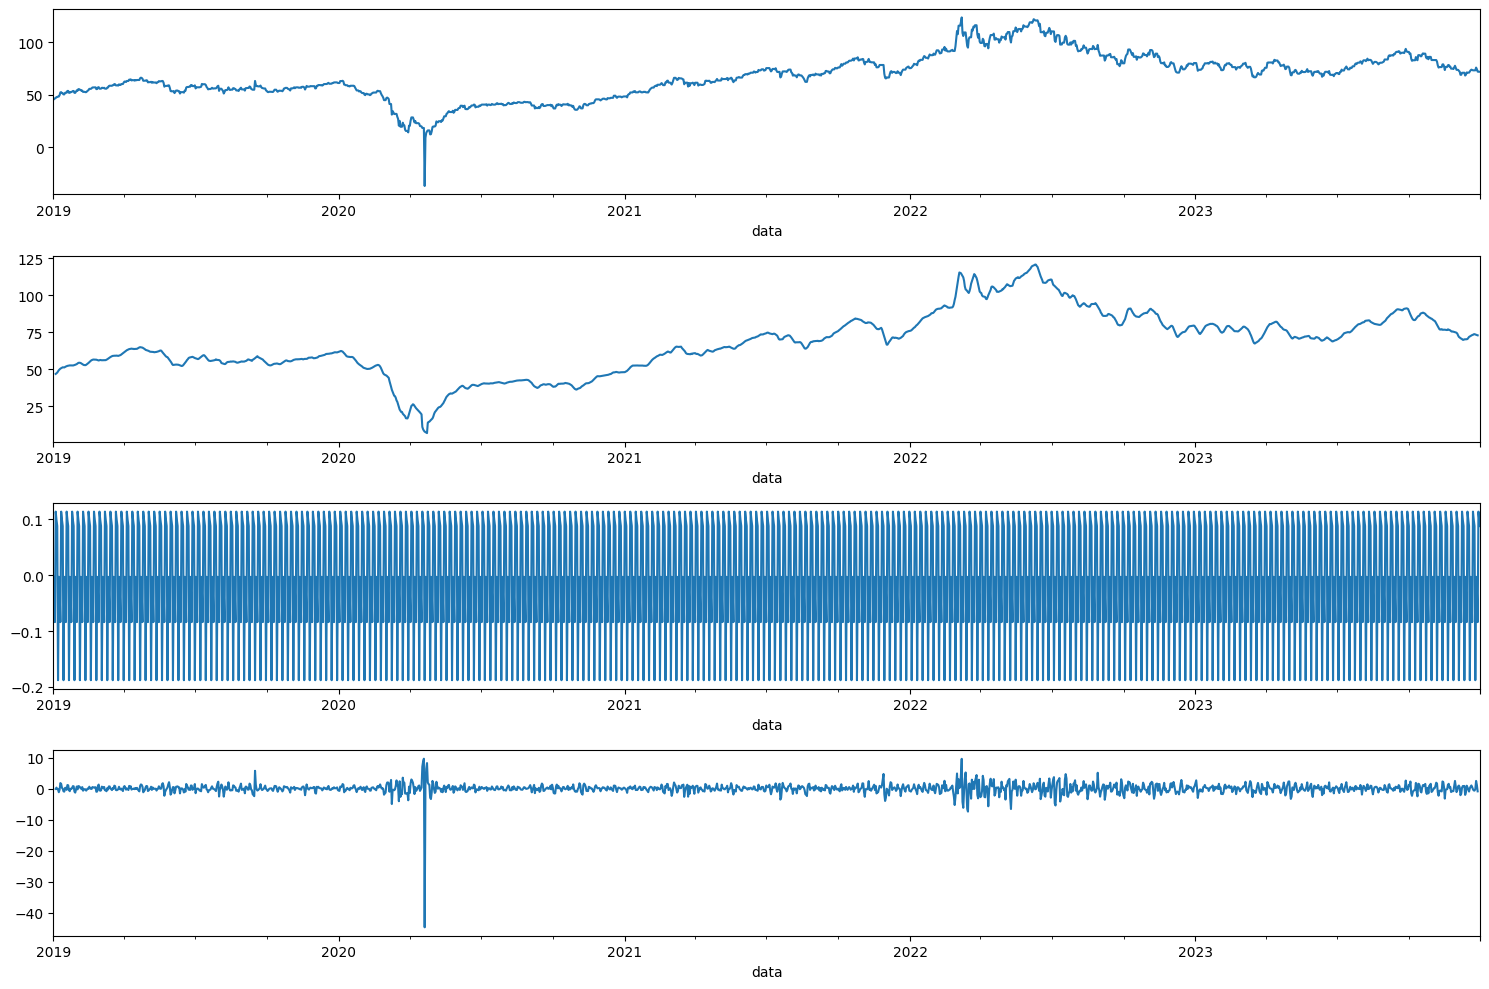

In [23]:
# Decompondo a série - sem parâmetros no seasonal decompose

resultados_2 = seasonal_decompose(df_analise)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (15,10))

resultados_2.observed.plot(ax=ax1) # gráfico completo da série
resultados_2.trend.plot(ax=ax2)    # gráfico da tendência
resultados_2.seasonal.plot(ax=ax3) # gráfico da sazonalidade
resultados_2.resid.plot(ax=ax4)   # gráfico de resíduos

plt.tight_layout();

# 3.0 EDA

In [15]:
# Criando um df para a EDA

df_eda = df_inicial_ajustado_2.copy()

# Criando uma coluna para ano e outro para o mês

df_eda['ano'] = df_eda.data.dt.year
df_eda['mes'] = df_eda.data.dt.month

# Selecionando apenas os valores, ano e mês

df_eda = df_eda[['ano', 'mes', 'novos_valores']]

In [16]:
df_eda_ano = df_eda.groupby(['ano'])['novos_valores'].mean().reset_index()
df_eda_ano.columns = ['ano', 'media_anual_preco_petroleo_usd']
df_eda_ano.media_anual_preco_petroleo_usd = round((df_eda_ano.media_anual_preco_petroleo_usd),1)

In [13]:
# Gráfico de do peço com NA's preenchidos por ano

preco_petro_anual = px.line(df_eda_ano, x='ano', y='media_anual_preco_petroleo_usd')
preco_petro_anual.update_xaxes(type='category')
preco_petro_anual.show();

In [15]:
# Análise descritiva dos preços no período selecionado

analise_descriritva_preco = round((df_inicial_ajustado_2.novos_valores.describe().reset_index()),2)
analise_descriritva_preco.columns = ['Medidas', 'Preço barril petróleo']
analise_descriritva_preco

,Medidas,Preço barril petróleo
0,count,4017.00
1,mean,66.90
2,std,22.04
3,min,-36.98
4,25%,49.37
5,50%,62.77
6,75%,83.55
7,max,123.64


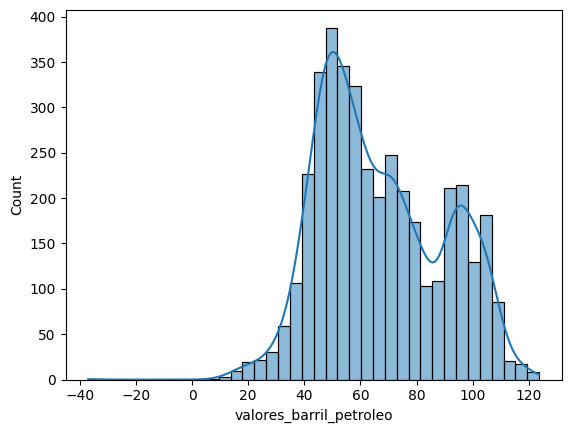

In [22]:
# Box plot dos dados

df_graficos_eda = df_inicial_ajustado_2[['data', 'novos_valores']]
df_graficos_eda.columns = ['data', 'valores_barril_petroleo']

sns.histplot(data=df_graficos_eda.valores_barril_petroleo, kde=True);

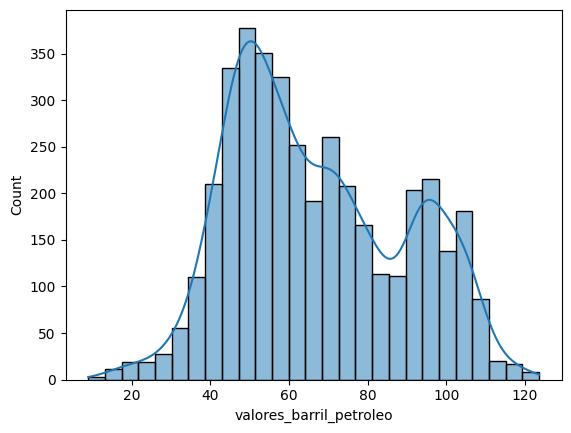

In [20]:
# Considerando apenas os valores positivos

df_graficos_eda_positivo = df_graficos_eda[df_graficos_eda.valores_barril_petroleo > 0]

sns.histplot(data=df_graficos_eda_positivo.valores_barril_petroleo, kde=True);

# 4.0 Modelo


## 4.0.1 Garantindo a ordem dos dados 

In [18]:
# Criando um df para o modelo

df_modelo = df_inicial_ajustado[['data', 'novos_valores']]
df_modelo.columns = ['data', 'novos_valores_preco_pet']
df_modelo = df_modelo.sort_values('data')

### 4.1.1 Definições do modelo 

In [67]:
df_temp = df_modelo.copy()

END_TREINO = dt.date(2023,12,15)
END_TREINO = pd.to_datetime(END_TREINO)
#TEST_PERIOD = dt.date(2023,12,31)
MAX_DATE = dt.date(2023,12,31)
MAX_DATE = pd.to_datetime(MAX_DATE)

In [68]:
X = df_modelo[['pandemia', 'data']]  # x = control nesse caso
y = df_modelo.rename(columns={'novos_valores_preco_pet':'y'})[['y', 'data']]


In [77]:
# separando os dados

df_y_train = y[y['data'] <= END_TREINO]
min_max(df_y_train)
print('y_train')


df_y_test = y[y['data'] > END_TREINO]
min_max(df_y_test)
print('y_test')

df_X_train = X[X['data'] <= END_TREINO]
min_max(df_X_train)
print('X_train')

df_X_test = X[X['data'] > END_TREINO]
min_max(df_X_test)
print('x_train')

menor data: 2019-01-01 00:00:00 maior data: 2023-12-15 00:00:00
y_train
menor data: 2023-12-16 00:00:00 maior data: 2023-12-31 00:00:00
y_test
menor data: 2019-01-01 00:00:00 maior data: 2023-12-15 00:00:00
X_train
menor data: 2023-12-16 00:00:00 maior data: 2023-12-31 00:00:00
x_train


## 4.2 SARIMAX 

In [88]:
df_y_train.dtypes

y              float64
data    datetime64[ns]
dtype: object

In [127]:
# Definindo as listas de parâmetros para teste

p_values = range(0, 3)  # substitua pelos valores que deseja testar
d_values = range(0, 2)  # substitua pelos valores que deseja testar
q_values = range(0, 3)  # substitua pelos valores que deseja testar
P_values = range(0, 3)  # substitua pelos valores que deseja testar
D_values = range(0, 2)  # substitua pelos valores que deseja testar
Q_values = range(0, 3)  # substitua pelos valores que deseja testar
seasonal_periods = [7, 14, 21]  # períodos sazonais a serem testados

# Gerando todas as combinações de parâmetros

param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_periods))



In [129]:
best_rmse, best_mape, best_cfg = float("inf"), float("inf"), None

for params in param_combinations:
    p, d, q, P, D, Q, m = params
    try:
        # Ajustando o modelo SARIMAX
        model = SARIMAX(endog=train['data'], order=(p, d, q), seasonal_order=(P, D, Q, m))
        model_fit = model.fit(disp=False)

        # Fazendo previsões
        y_pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

        # Calculando RMSE
        rmse = np.sqrt(mean_squared_error(test['data'], y_pred))

        # Calculando MAPE
        ape = np.abs((test['data'] - y_pred) / test['data'])
        mape = np.mean(ape) * 100

        # Salvando o melhor modelo baseado no RMSE
        if rmse < best_rmse:
            best_rmse, best_mape, best_cfg = rmse, mape, params

        print(f'ARIMA{params} - RMSE: {rmse:.3f}, MAPE: {mape:.3f}%')
    except:
        continue

print(f'Melhor Modelo: ARIMA{best_cfg} - RMSE: {best_rmse:.3f}, MAPE: {best_mape:.3f}%')


ARIMA(0, 0, 0, 0, 0, 0, 7) - RMSE: 3.632, MAPE: 100.000%
ARIMA(0, 0, 0, 0, 0, 0, 14) - RMSE: 3.632, MAPE: 100.000%
ARIMA(0, 0, 0, 0, 0, 0, 21) - RMSE: 3.632, MAPE: 100.000%
ARIMA(0, 0, 0, 0, 0, 1, 7) - RMSE: 3.381, MAPE: 95.479%
ARIMA(0, 0, 0, 0, 0, 1, 14) - RMSE: 3.457, MAPE: 114.227%
ARIMA(0, 0, 0, 0, 0, 1, 21) - RMSE: 2.627, MAPE: 68.607%
ARIMA(0, 0, 0, 0, 0, 2, 7) - RMSE: 3.088, MAPE: 98.810%
ARIMA(0, 0, 0, 0, 0, 2, 14) - RMSE: 3.424, MAPE: 110.018%
ARIMA(0, 0, 0, 0, 0, 2, 21) - RMSE: 3.004, MAPE: 81.132%
ARIMA(0, 0, 0, 0, 1, 0, 7) - RMSE: 4.116, MAPE: 147.848%
ARIMA(0, 0, 0, 0, 1, 0, 14) - RMSE: 3.874, MAPE: 139.159%
ARIMA(0, 0, 0, 0, 1, 0, 21) - RMSE: 6.145, MAPE: 177.271%
ARIMA(0, 0, 0, 0, 1, 1, 7) - RMSE: 3.602, MAPE: 118.739%
ARIMA(0, 0, 0, 0, 1, 1, 14) - RMSE: 3.908, MAPE: 142.292%
ARIMA(0, 0, 0, 0, 1, 1, 21) - RMSE: 4.342, MAPE: 121.743%
ARIMA(0, 0, 0, 0, 1, 2, 7) - RMSE: 5.447, MAPE: 218.402%
ARIMA(0, 0, 0, 0, 1, 2, 14) - RMSE: 3.609, MAPE: 132.263%
ARIMA(0, 0, 0, 0, 1, 2, 

In [130]:
ORDER = (2,0,2)
SEASONAL_ORDER = (0,0,2,21)
sarimax = SARIMAX(
    endog = df_y_train[['y']],
    #exog = df_X_train['pandemia'], 
    order=ORDER,  
    seasonal_order=SEASONAL_ORDER
)

sarimax_res = sarimax.fit(disp=False)



mae = np.mean(np.abs(sarimax_res.resid))


sarimax_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1810
Model:             SARIMAX(2, 0, 2)x(0, 0, 2, 21)   Log Likelihood               -4021.716
Date:                            Mon, 01 Jul 2024   AIC                           8057.431
Time:                                    16:52:37   BIC                           8095.939
Sample:                                         0   HQIC                          8071.642
                                           - 1810                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5902      0.171      9.284      0.000       1.255       1.926
ar.L2         -0.5904      0.171     -3.450      0.001      -0.926      -0.255
ma.L1         -0.8502      0.170     -4.999      0.000      -1.184      -0.517
ma.L2          0.1132      0.048      2.340      0.019       0.018       0.208
ma.S.L21       0.0703      0.020      3.550      0.000       0.031       0.109
ma.S.L42       0.1010      0.014      7.024      0.000       0.073       0.129
sigma2         4.9636      0.032    156.922      0.000       4.902       5.026
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           3590781.90
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -6.82
Prob(H) (two-sided):                  0.00   Kurtosis:                       220.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

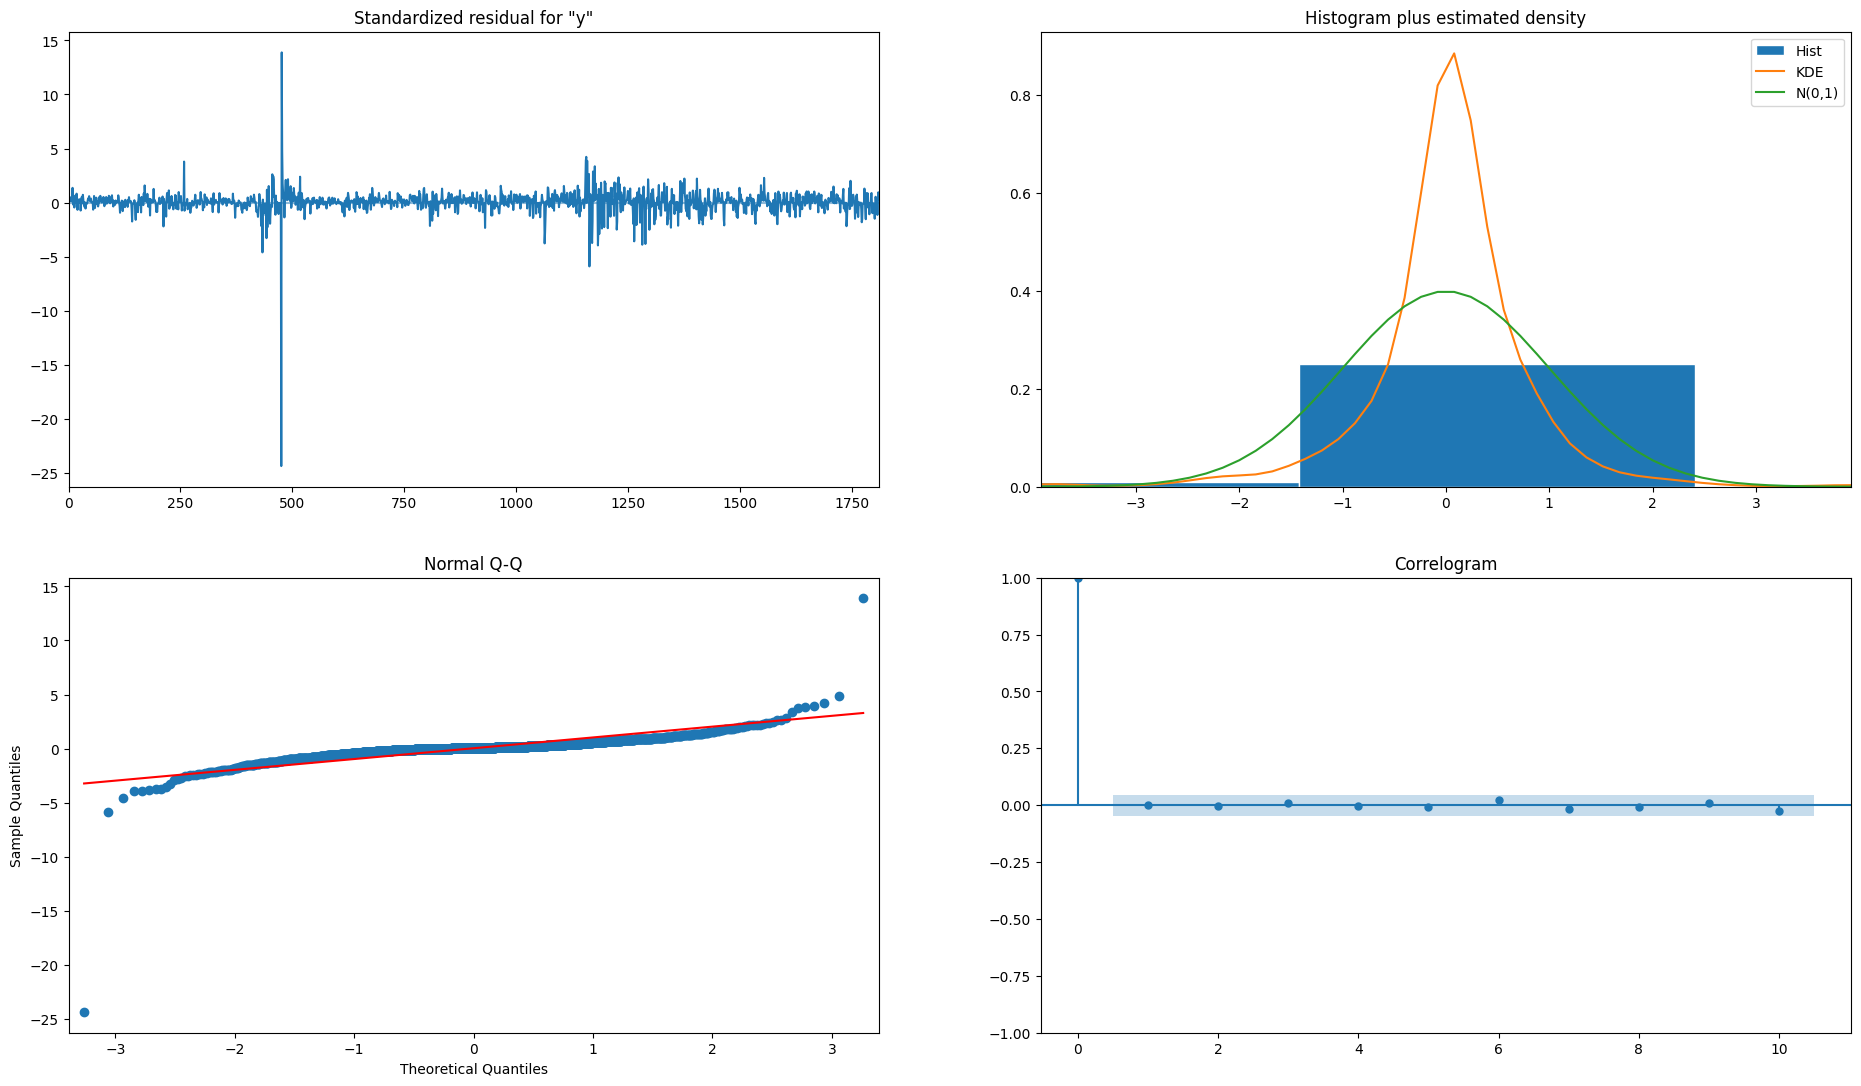

In [131]:
sarimax_res.plot_diagnostics(figsize=(23, 13))
plt.show()

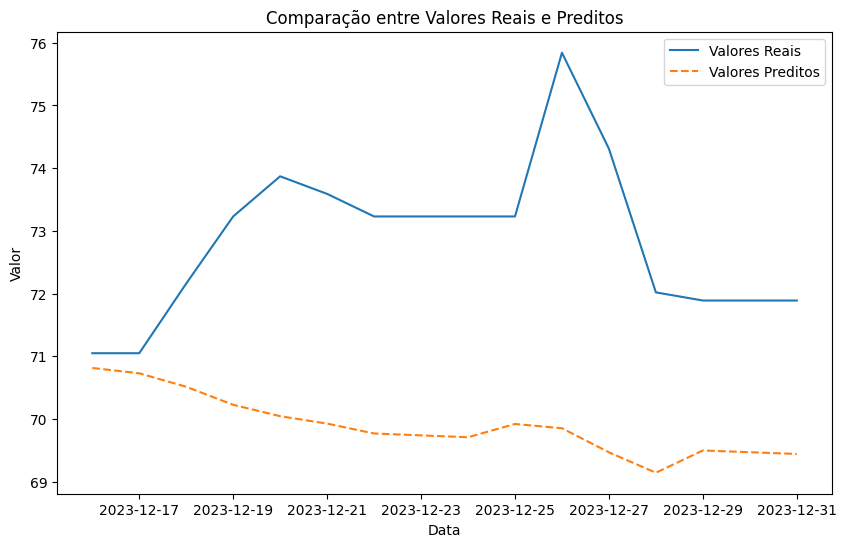

In [134]:
plt.figure(figsize=(10, 6))
plt.plot(df_y_test['data'], df_y_test['y'], label='Valores Reais')
plt.plot(df_y_test['data'], y_pred, label='Valores Preditos', linestyle='--')
plt.title('Comparação entre Valores Reais e Preditos')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

## 4.3 Prophet

In [160]:
df_y_train_prophet = df_y_train.rename(columns = {'data':'ds'})
df_y_test_prophet = df_y_test.rename(columns = {'data':'ds'})

In [185]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(df_y_train_prophet)
dataFramefuture = modelo.make_future_dataframe(periods=15, freq='D')
previsao = modelo.predict(dataFramefuture)
previsao.head()

19:40:05 - cmdstanpy - INFO - Chain [1] start processing
19:40:05 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,45.823086,44.394825,57.412915,45.823086,45.823086,5.037847,5.037847,5.037847,5.290655,...,-0.023846,-0.023846,-0.023846,-0.228961,-0.228961,-0.228961,0.0,0.0,0.0,50.860933
1,2019-01-02,45.881793,43.972244,57.738754,45.881793,45.881793,5.163748,5.163748,5.163748,5.290655,...,-0.040238,-0.040238,-0.040238,-0.086669,-0.086669,-0.086669,0.0,0.0,0.0,51.045541
2,2019-01-03,45.940500,44.219354,57.726788,45.940500,45.940500,5.250290,5.250290,5.250290,5.290655,...,-0.091172,-0.091172,-0.091172,0.050807,0.050807,0.050807,0.0,0.0,0.0,51.190790
3,2019-01-04,45.999207,44.703570,58.576242,45.999207,45.999207,5.579831,5.579831,5.579831,5.290655,...,0.104872,0.104872,0.104872,0.184305,0.184305,0.184305,0.0,0.0,0.0,51.579039
4,2019-01-05,46.057915,44.829453,58.293976,46.057915,46.057915,5.722108,5.722108,5.722108,5.290655,...,0.116877,0.116877,0.116877,0.314576,0.314576,0.314576,0.0,0.0,0.0,51.780022


In [187]:
previsao[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-01,50.860933,44.394825,57.412915
1,2019-01-02,51.045541,43.972244,57.738754
2,2019-01-03,51.190790,44.219354,57.726788
3,2019-01-04,51.579039,44.703570,58.576242
4,2019-01-05,51.780022,44.829453,58.293976


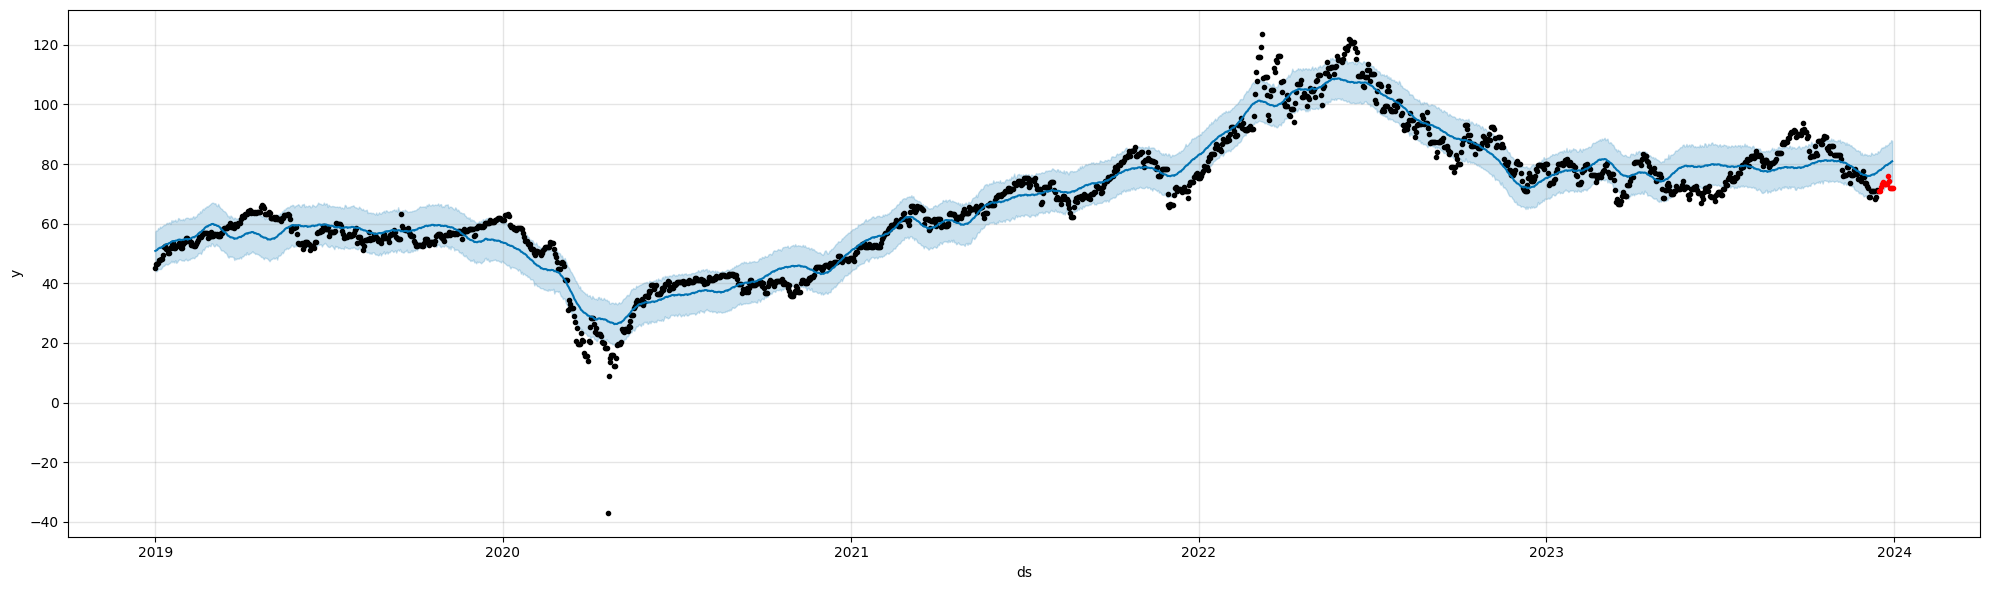

In [188]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(df_y_test_prophet['ds'], df_y_test_prophet['y'], '.r')

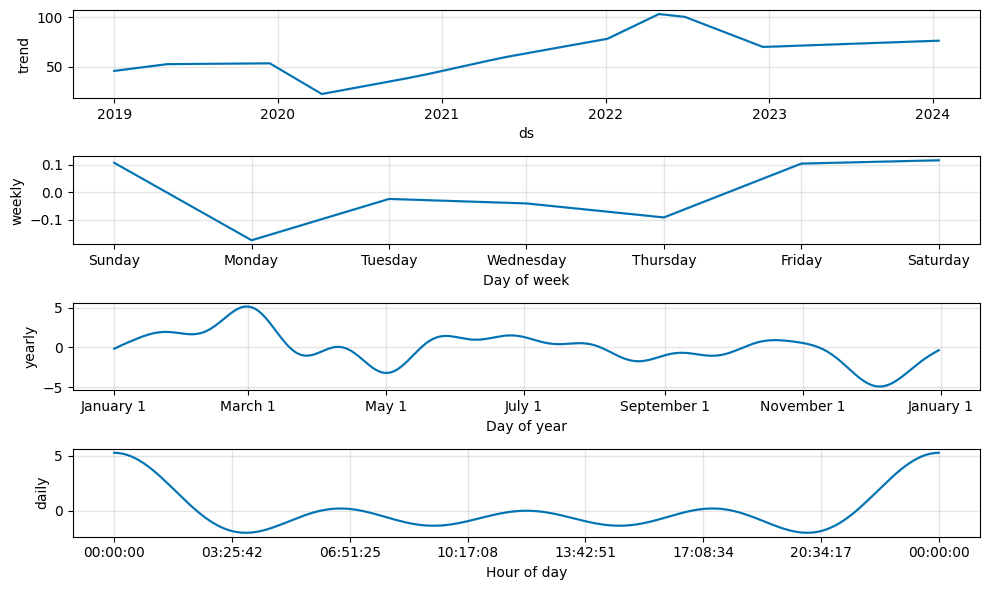

In [162]:
modelo.plot_components(previsao, figsize=(10,6));

In [163]:
modelo_changepoints = Prophet(n_changepoints=5)
modelo_changepoints.fit(df_y_test_prophet)
dataFramefuture = modelo_changepoints.make_future_dataframe(periods=30, freq='D')
previsao_changepoints = modelo_changepoints.predict(dataFramefuture)
previsao_changepoints.head()

17:16:04 - cmdstanpy - INFO - Chain [1] start processing
17:16:04 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-12-16,71.474801,70.365227,71.401024,71.474801,71.474801,-0.620708,-0.620708,-0.620708,-0.620708,-0.620708,-0.620708,0.0,0.0,0.0,70.854093
1,2023-12-17,71.839684,70.711260,71.758882,71.839684,71.839684,-0.611956,-0.611956,-0.611956,-0.611956,-0.611956,-0.611956,0.0,0.0,0.0,71.227728
2,2023-12-18,72.204567,71.426678,72.443952,72.204567,72.204567,-0.270041,-0.270041,-0.270041,-0.270041,-0.270041,-0.270041,0.0,0.0,0.0,71.934527
3,2023-12-19,72.569450,73.512223,74.576716,72.569450,72.569450,1.507295,1.507295,1.507295,1.507295,1.507295,1.507295,0.0,0.0,0.0,74.076745
4,2023-12-20,72.934333,73.410022,74.480863,72.934333,72.934333,0.999556,0.999556,0.999556,0.999556,0.999556,0.999556,0.0,0.0,0.0,73.933889


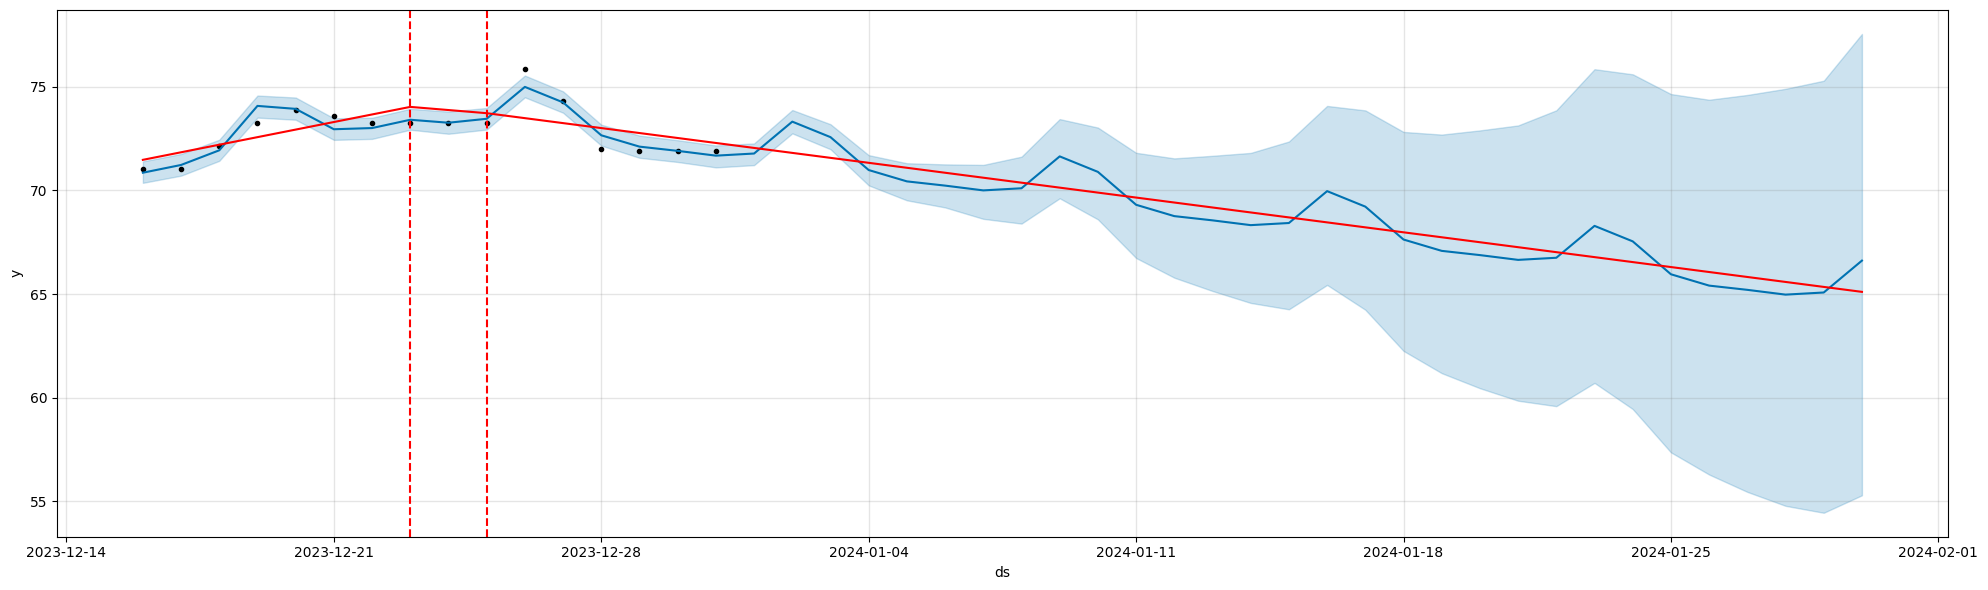

In [164]:
fig = modelo_changepoints.plot(previsao_changepoints, figsize=(20,6));
a = add_changepoints_to_plot(fig.gca(), modelo_changepoints, previsao_changepoints)

In [166]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = df_y_train_prophet[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 7.48%
